# Imports and configs

In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from autogluon.tabular import TabularPredictor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import pickle
import shutil
import os

warnings.filterwarnings('ignore')

In [2]:
class CFG:
    train_path = '/kaggle/input/playground-series-s5e3/train.csv'
    test_path = '/kaggle/input/playground-series-s5e3/test.csv'
    sample_sub_path = '/kaggle/input/playground-series-s5e3/sample_submission.csv'
    original_path = '/kaggle/input/rainfall-prediction-using-machine-learning/Rainfall.csv'
    
    target = 'rainfall'
    n_folds = 5
    seed = 42
    time_limit = 3600 * 11

# Loading data and predefining folds

In [3]:
train = pd.read_csv(CFG.train_path, index_col='id')
test = pd.read_csv(CFG.test_path, index_col='id')

original = pd.read_csv(CFG.original_path)
original.columns = original.columns.str.replace(" ", "")
original[CFG.target] = original[CFG.target].map({"yes": 1, "no": 0})
original['humidity'] = original['humidity'].astype(float)
original['cloud'] = original['windspeed'].astype(float)
original = original.dropna().reset_index(drop=True)
original["id"] = train.index.max() + 1 + original.index
original = original.set_index("id")

In [4]:
skf = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = skf.split(train, train[CFG.target])
for i, (_, val_index) in enumerate(split):
    train.loc[val_index, 'fold'] = i

# Fitting the predictor

In [5]:
predictor = TabularPredictor(
    path='/AutoGluonModels',
    problem_type='binary',
    eval_metric='roc_auc',
    label=CFG.target,
    groups='fold',
    verbosity=2
)

In [6]:
predictor.fit(
    # pseudo_data=original,
    train_data=train,
    time_limit=CFG.time_limit,
    presets='best_quality'
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       30.27 GB / 31.35 GB (96.5%)
Disk Space Avail:   1892.13 GB / 8062.39 GB (23.5%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stac

(_ray_fit pid=8696) [1000]	valid_set's binary_logloss: 0.289544
(_ray_fit pid=8821) [1000]	valid_set's binary_logloss: 0.316864 [repeated 4x across cluster]


(_dystack pid=164) 	0.893	 = Validation score   (roc_auc)
(_dystack pid=164) 	10.1s	 = Training   runtime
(_dystack pid=164) 	0.35s	 = Validation runtime
(_dystack pid=164) Fitting model: RandomForest_r39_BAG_L1 ... Training model for up to 5801.32s of the 9101.27s of remaining time.
(_dystack pid=164) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=164) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=164) 	0.8784	 = Validation score   (roc_auc)
(_dystack pid=164) 	10.09s	 = Training   runtime
(_dystack pid=164) 	0.67s	 = Validation runtime
(_dystack pid=164) Fitting model: CatBoost_r167_BAG_L1 ... Training model for up to 5787.46s of the 9087.41s of remaining time.
(_dystack pid=164) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)
(_dystack pid=164) 	0.891	 = Validation score  

(_ray_fit pid=29969) [1000]	valid_set's binary_logloss: 0.326782
(_ray_fit pid=29966) [1000]	valid_set's binary_logloss: 0.278017
(_ray_fit pid=30092) [1000]	valid_set's binary_logloss: 0.313847


(_dystack pid=164) 	0.8936	 = Validation score   (roc_auc)
(_dystack pid=164) 	10.66s	 = Training   runtime
(_dystack pid=164) 	0.27s	 = Validation runtime
(_dystack pid=164) Fitting model: RandomForest_r39_BAG_L2 ... Training model for up to 6859.22s of the 6858.92s of remaining time.
(_dystack pid=164) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=164) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=164) 	0.8874	 = Validation score   (roc_auc)
(_dystack pid=164) 	16.92s	 = Training   runtime
(_dystack pid=164) 	0.56s	 = Validation runtime
(_dystack pid=164) Fitting model: CatBoost_r167_BAG_L2 ... Training model for up to 6838.57s of the 6838.27s of remaining time.
(_dystack pid=164) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.32%)
(_dystack pid=164) 	0.8961	 = Validation scor

In [7]:
def get_ensemble_weights(predictor):
    selected_models = []
    info = predictor.info()
    ensemble_weights = {}
    for model_name, values in info["model_info"].items():
        if "Ensemble" in model_name:
            children_info = values["children_info"]
            ensemble_weights[model_name] = values["children_info"][list(children_info.keys())[0]]["model_weights"]
            selected_models.extend(values["children_info"][list(children_info.keys())[0]]["model_weights"].keys())
            selected_models.append(model_name)
    return ensemble_weights, list(set(selected_models))

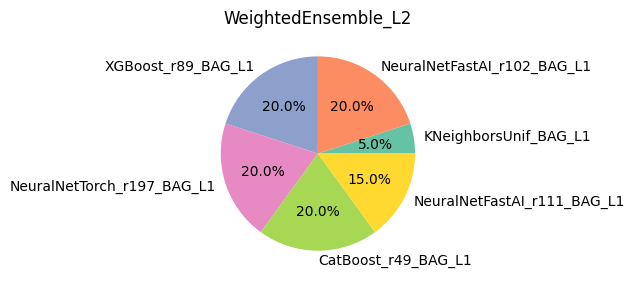

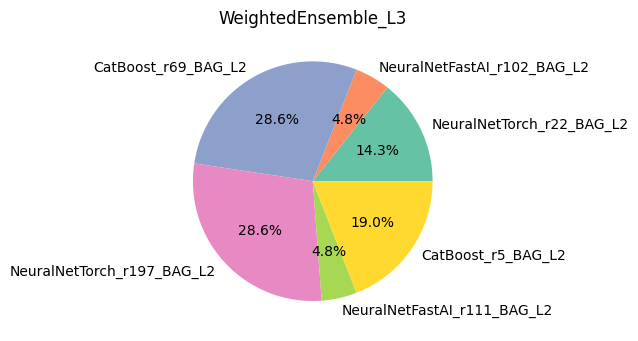

In [8]:
ensemble_weights, selected_models = get_ensemble_weights(predictor)

for key, value in ensemble_weights.items():
    plt.figure(figsize=(6, 6))
    plt.pie(value.values(), labels=value.keys(), autopct='%1.1f%%', colors=sns.color_palette('Set2', len(value)))
    plt.title(key)
    plt.tight_layout()
    plt.show()

In [9]:
predictor.leaderboard(silent=True)[predictor.leaderboard(silent=True).model.isin(selected_models)].style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.899698,roc_auc,0.931771,129.751490,0.000931,0.264765,2,True,111
1,WeightedEnsemble_L3,0.898263,roc_auc,5.403230,382.618343,0.000956,0.304395,3,True,220
2,NeuralNetTorch_r197_BAG_L2,0.895912,roc_auc,4.241561,237.274885,0.159341,17.840826,2,True,163
3,CatBoost_r69_BAG_L2,0.895758,roc_auc,4.109758,230.265779,0.027537,10.831720,2,True,146
4,CatBoost_r5_BAG_L2,0.895754,roc_auc,4.111227,228.175092,0.029006,8.741033,2,True,180
7,CatBoost_r49_BAG_L1,0.895008,roc_auc,0.010511,6.552236,0.010511,6.552236,1,True,55
8,NeuralNetTorch_r22_BAG_L2,0.894913,roc_auc,4.265618,243.050182,0.183398,23.616123,2,True,129
13,NeuralNetFastAI_r111_BAG_L2,0.893827,roc_auc,4.601872,267.210644,0.519651,47.776584,2,True,173
15,NeuralNetFastAI_r102_BAG_L2,0.893793,roc_auc,4.483342,273.507661,0.401121,54.073602,2,True,133
24,NeuralNetFastAI_r102_BAG_L1,0.893260,roc_auc,0.385303,50.395050,0.385303,50.395050,1,True,24


# Collecting and saving OOF files

In [10]:
def save_pred_probs(pred_probs, cv_score, name, type, is_ensemble):
    base_path = 'oof_pred_probs' if type == 'oof' else 'test_pred_probs'
    base_path = '.' if is_ensemble else base_path
    with open(f'{base_path}/{name}_{type}_pred_probs_{cv_score:.6f}.pkl', 'wb') as f:
        pickle.dump(pred_probs, f)

def save_submission(test_pred_probs, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = test_pred_probs
    sub.to_csv(f'sub_autogluon_{score:.6f}.csv', index=False)
    
os.makedirs('oof_pred_probs', exist_ok=True)
os.makedirs('test_pred_probs', exist_ok=True)

In [11]:
oof_pred_probs = {}
test_pred_probs = {}

In [12]:
best_model = predictor.model_best
test_pred_probs = predictor.predict_proba_multi(test)
for model in predictor.model_names():
    model_oof_pred_probs = predictor.predict_proba_oof(model).values[:, 1]
    model_test_pred_probs = test_pred_probs[model].values[:, 1]
    
    cv_score = roc_auc_score(train[CFG.target], model_oof_pred_probs)
    if model != best_model:
        save_pred_probs(model_oof_pred_probs, cv_score, model, 'oof', False)
        save_pred_probs(model_test_pred_probs, cv_score, model, 'test', False)
    else:
        save_pred_probs(model_oof_pred_probs, cv_score, model, 'oof', True)
        save_pred_probs(model_test_pred_probs, cv_score, model, 'test', True)
        save_submission(model_test_pred_probs, cv_score)
        
    oof_pred_probs[model] = model_oof_pred_probs
    test_pred_probs[model] = model_test_pred_probs

INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.

# Visualizing the results

In [13]:
scores = {}
split = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(train, train[CFG.target])
for fold_idx, (train_index, val_index) in enumerate(split):
    for model in predictor.model_names():
        fold_score = roc_auc_score(train.loc[val_index, CFG.target], oof_pred_probs[model][val_index])
        if model not in scores:
            scores[model] = []
        scores[model].append(fold_score)

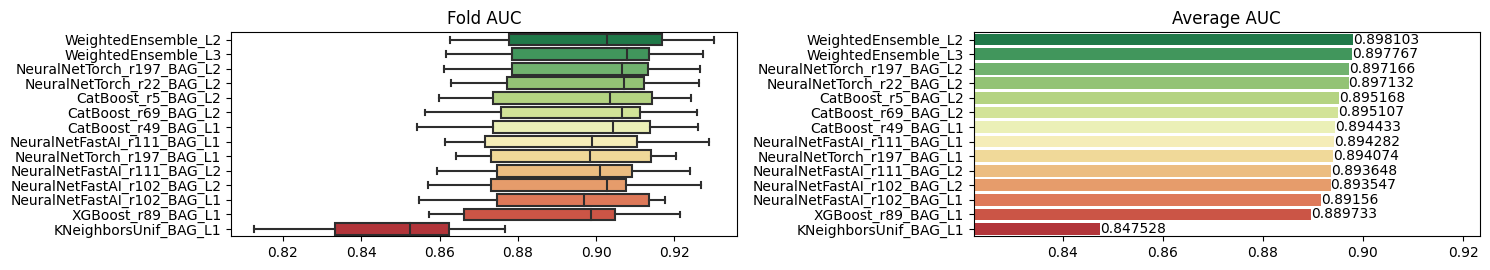

In [14]:
scores = pd.DataFrame(scores)[selected_models]
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.2))

sns.boxplot(data=scores, order=order, ax=axs[0], orient='h', palette='RdYlGn_r')
axs[0].set_title('Fold AUC')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], palette='RdYlGn_r')
axs[1].set_title('Average AUC')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 6), va='center')

plt.tight_layout()
plt.show()